In [49]:
# !pip install opencv-python numpy matplotlib pytesseract tensorflow

Car Plate Detection with OpenCV and TesseractOCR in Python


 

___
<a name="section-1"></a>
## 1 - Car Plate Detection with OpenCV and Haar Cascade

#### Getting started with image preparation

In [50]:
# Import dependencies
import cv2 
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pytesseract

# Set tesseract path to where the tesseract exe file is located (Edit this path accordingly based on your own settings)
pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe'

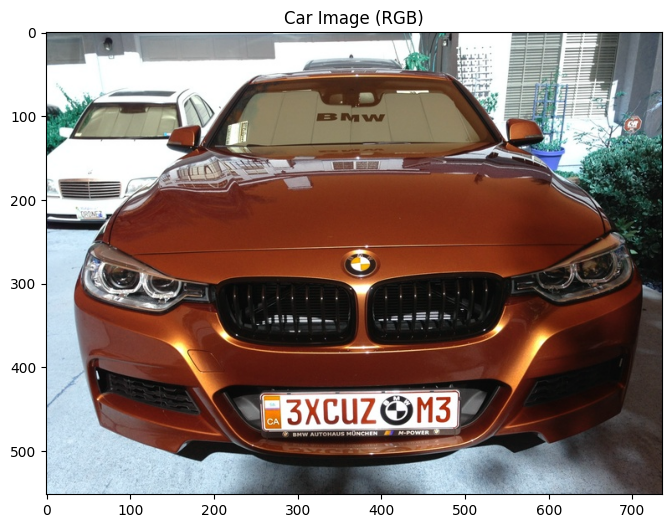

In [51]:
# Read car image and convert color to RGB
carplate_img = cv2.imread('./images/image2.png')
carplate_img_rgb = cv2.cvtColor(carplate_img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(8,6))
plt.imshow(carplate_img)
plt.title("Car Image (RGB)")
plt.show()

In [52]:
# Function to enlarge the plt display for user to view more clearly
def enlarge_plt_display(image, scale_factor):
    width = int(image.shape[1] * scale_factor / 100)
    height = int(image.shape[0] * scale_factor / 100)
    dim = (width, height)
    plt.figure(figsize = dim)
    plt.axis('off') 
    plt.imshow(image)

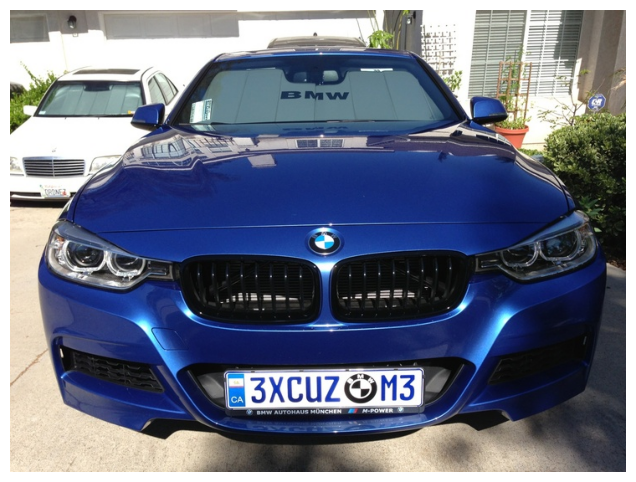

In [53]:
enlarge_plt_display(carplate_img_rgb, 1.2)

In [54]:
# Import Haar Cascade XML file for car plate numbers
carplate_haar_cascade = cv2.CascadeClassifier('./haar_cascades/haarcascade_russian_plate_number.xml')

In [55]:
# Setup function to detect car plate
def carplate_detect(image):
    carplate_overlay = image.copy() # Create overlay to display red rectangle of detected car plate
    carplate_rects = carplate_haar_cascade.detectMultiScale(carplate_overlay,scaleFactor=1.1, minNeighbors=5) 

    for x,y,w,h in carplate_rects: 
        cv2.rectangle(carplate_overlay, (x,y), (x+w,y+h), (255,0,0), 5) 
        
    return carplate_overlay

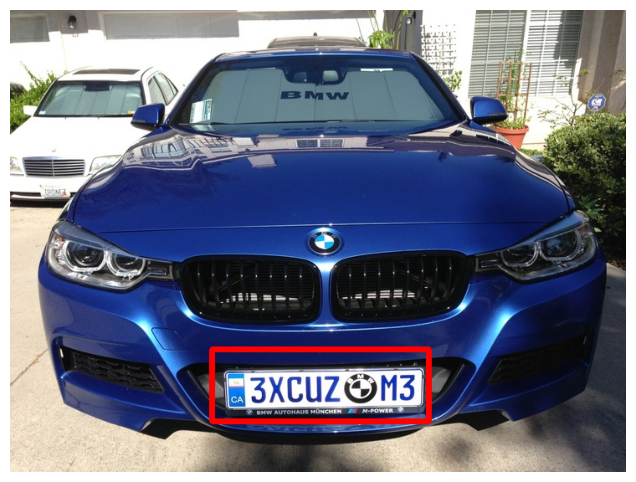

In [56]:
detected_carplate_img = carplate_detect(carplate_img_rgb)
enlarge_plt_display(detected_carplate_img, 1.2)

___
<a name="section-2"></a>
## 2 - Car Plate Number Recognition and Extraction with TesseractOCR

#### Extract car license plate

In [57]:
# Function to retrieve only the car plate sub-image itself
def carplate_extract(image):
    
    carplate_rects = carplate_haar_cascade.detectMultiScale(image,scaleFactor=1.1, minNeighbors=5) 

    for x,y,w,h in carplate_rects: 
        carplate_img = image[y+15:y+h-10 ,x+15:x+w-20] 
        
    return carplate_img

In [58]:
# Enlarge image for further image processing later on
def enlarge_img(image, scale_percent):
    width = int(image.shape[1] * scale_percent / 100)
    height = int(image.shape[0] * scale_percent / 100)
    dim = (width, height)
    resized_image = cv2.resize(image, dim, interpolation = cv2.INTER_AREA)
    return resized_image

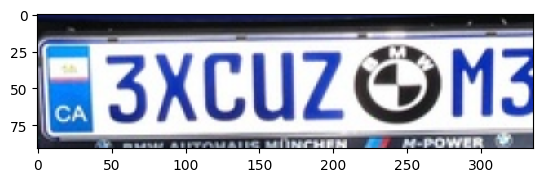

In [59]:
# Display extracted car license plate image
carplate_extract_img = carplate_extract(carplate_img_rgb)
carplate_extract_img = enlarge_img(carplate_extract_img, 150)
plt.imshow(carplate_extract_img);

#### Begin series of image processing to improve accuracy of TesseractOCR's results

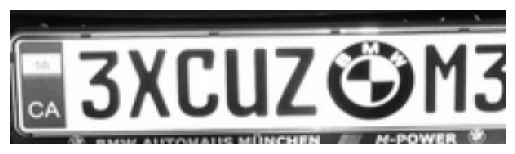

In [60]:
# Convert image to grayscale
carplate_extract_img_gray = cv2.cvtColor(carplate_extract_img, cv2.COLOR_RGB2GRAY)
plt.axis('off') 
plt.imshow(carplate_extract_img_gray, cmap = 'gray');

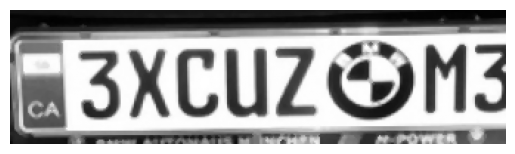

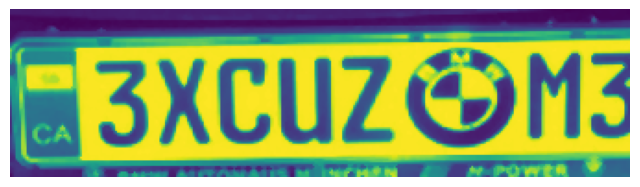

In [61]:
# Apply median blur + grayscale
carplate_extract_img_gray_blur = cv2.medianBlur(carplate_extract_img_gray,3) # Kernel size 3
plt.axis('off') 
plt.imshow(carplate_extract_img_gray_blur, cmap = 'gray');
plt.figure(figsize=(8, 4))  # adjust figure size if needed
plt.axis('off')              # hide axes
plt.imshow(carplate_extract_img_gray_blur)  # show the image
plt.show()

In [62]:
# Display the text extracted from the car plate
print(pytesseract.image_to_string(carplate_extract_img_gray_blur, 
                                  config = f'--psm 8 --oem 3 -c tessedit_char_whitelist=ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789'))

SXCUZGM2



The printed text above does match with the number text in our image.

In [63]:
# Testing all PSM values
for i in range(3,14):
    print(f'PSM: {i}')
    print(pytesseract.image_to_string(carplate_extract_img_gray_blur, 
                                      config = f'--psm {i} --oem 3 -c tessedit_char_whitelist=ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789'))

PSM: 3
3XCUZCOM

PSM: 4
3XCUZCOM

PSM: 5
2
N
O
IN

PSM: 6
SXCUZGM2

PSM: 7
SXCUZGM2

PSM: 8
SXCUZGM2

PSM: 9
5

PSM: 10
SXCUZGM2

PSM: 11
3XCUZCOM

PSM: 12
3XCUZCOM

PSM: 13
SXCUZGM2



___
## 3 - Serial Number Verification with MNIST and CNN Keras

Here we will train a CNN on the MNIST dataset and use it to verify/recognize the digits in the detected license plate.

In [64]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Sequential
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, accuracy_score

# Load MNIST dataset
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

# Normalize and reshape
x_train = x_train / 255.0
x_test = x_test / 255.0
x_train = x_train.reshape(-1, 28, 28, 1)
x_test = x_test.reshape(-1, 28, 28, 1)

# Build CNN Model
model = keras.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(10, activation='softmax')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

print("Training MNIST Model...")
model.fit(x_train, y_train, epochs=3, validation_data=(x_test, y_test), verbose=1)
y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)

print("Accuracy:", accuracy_score(y_test, y_pred_classes))
print(classification_report(y_test, y_pred_classes))


Training MNIST Model...
Epoch 1/3


c:\Users\Hassen\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1875/1875 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.8922 - loss: 0.3380 - val_accuracy: 0.9865 - val_loss: 0.0426
Epoch 2/3
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.9849 - loss: 0.0458 - val_accuracy: 0.9827 - val_loss: 0.0490
Epoch 3/3
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.9897 - loss: 0.0337 - val_accuracy: 0.9894 - val_loss: 0.0320
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Accuracy: 0.9894
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       980
           1       0.99      1.00      0.99      1135
           2       0.98      1.00      0.99      1032
           3       0.99      0.99      0.99      1010
           4       0.99      1.00      1.00       982
           5       0.97      0.99      0.98       892
           6       0.99      0.99      0.99       958
           7       1.00      0.97      0.98      1028
           8       0.99      0.98      0.99       974
           9       0.99

In [65]:
#logisticRegression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


LogisticRegressionmodel = LogisticRegression(max_iter=1000)
LogisticRegressionmodel.fit(x_train.reshape(len(x_train), -1), y_train)
y_pred = LogisticRegressionmodel.predict(x_test.reshape(len(x_test), -1))

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))



Accuracy: 0.9263

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.98      0.96       980
           1       0.96      0.98      0.97      1135
           2       0.93      0.90      0.92      1032
           3       0.91      0.91      0.91      1010
           4       0.94      0.94      0.94       982
           5       0.90      0.87      0.88       892
           6       0.94      0.95      0.95       958
           7       0.93      0.92      0.93      1028
           8       0.89      0.88      0.88       974
           9       0.91      0.92      0.91      1009

    accuracy                           0.93     10000
   macro avg       0.93      0.93      0.93     10000
weighted avg       0.93      0.93      0.93     10000



In [66]:
def class_to_char(class_id):
    if class_id < 10:
        return str(class_id)
    else:
        return chr(ord('A') + class_id - 10)

def extract_and_predict_characters(image, model):
    _, thresh = cv2.threshold(
        image, 0, 255,
        cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU
    )

    contours, _ = cv2.findContours(
        thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
    )

    candidates = []
    h_img, _ = image.shape

    for c in contours:
        x, y, w, h = cv2.boundingRect(c)
        if h > h_img * 0.3:
            candidates.append((x, y, w, h))

    candidates.sort(key=lambda x: x[0])

    plt.figure(figsize=(12, 3))
    predicted_text = ""

    for i, (x, y, w, h) in enumerate(candidates):
        roi = thresh[y:y+h, x:x+w]

        h_roi, w_roi = roi.shape
        scale = 20.0 / max(h_roi, w_roi)
        new_h, new_w = int(h_roi * scale), int(w_roi * scale)

        resized = cv2.resize(roi, (new_w, new_h))

        padded = np.zeros((28, 28), dtype=np.uint8)
        pad_y = (28 - new_h) // 2
        pad_x = (28 - new_w) // 2
        padded[pad_y:pad_y+new_h, pad_x:pad_x+new_w] = resized

        input_data = padded / 255.0
        input_data = input_data.reshape(1, 28, 28, 1)

        prediction = model.predict(input_data, verbose=0)
        class_id = np.argmax(prediction)

        # TEMPORARY: will still be digit-only if model has 10 classes
        char = str(class_id) if prediction.shape[1] == 10 else class_to_char(class_id)
        predicted_text += char

        plt.subplot(1, len(candidates), i + 1)
        plt.imshow(padded, cmap="gray")
        plt.title(f"Pred: {char}")
        plt.axis("off")

    plt.show()
    return predicted_text
    
   

Detected Digits using CNN:


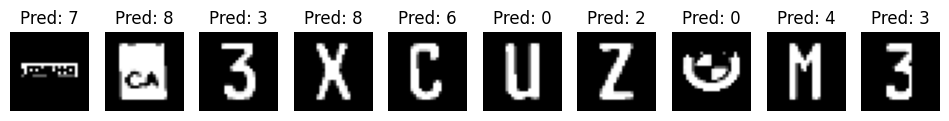

CNN Result: 7838602043


In [67]:
print("Detected Digits using CNN:")
# Using the blurred grayscale image from previous steps
cnn_result = extract_and_predict_characters(carplate_extract_img_gray_blur, model)
print(f"CNN Result: {cnn_result}")